In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io
from mpl_toolkits import mplot3d
import pickle
import numpy as np
import scipy.io.wavfile
from scipy.signal import convolve2d
import sys
import tpt_tools
from IPython.display import display, Audio

do_student = True
%matplotlib widget

In [2]:
def remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 1000) :
    """
    Renvoie le signal tronqué avec le vecteurs temps associé

    # Inputs
    - sig : signal audio à tronquer
    - fs : fréquence d'échantillonnage (utile pour regénérer le vecteur temps)
    - ratio_parameter : paramètre à adapter pour couper plus ou moins le bruit. 6 par défaut

    # Ouputs
    - time : nouveau vecteur temps
    - sig : nouveau signal audio tronqué
    """
    sig /= np.max(np.abs(sig))
    noise = sig[:len_noise]
    if method == "mean" :
        noise_threshold = np.mean(np.abs(noise))
    elif method == "max" :
        noise_threshold = np.max(np.abs(noise))

    i=0
    while np.abs(sig[i]) < ratio_parameter*noise_threshold :
        i += 1
    #i correspond au premier indice au dessus du seuil
    sig = sig[i:]
    time = np.arange(len(sig))/fs
    return time, sig

In [3]:
def F_getSpectreFromAudio(x, L_n, Nfft, sr_hz):
    """
    inputs:
        - x: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the DFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the DFT amplitudes
    """
    
    if do_student:
        window = np.hamming(L_n)
        x_new = x[:L_n]*window
        fftFreq_hz_v=np.linspace(0,sr_hz,Nfft)
        fftAmpl_v = np.abs(np.fft.fft(x_new, Nfft))


    return fftFreq_hz_v, fftAmpl_v

def F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes 
        - f0_hz: estimated F0 in Hz
    """
    
    if do_student:
        X = fftAmpl_v
        R_max = (int(Nfft/(2*H)))
        P = np.copy(fftAmpl_v)
        
        for h in range(2,H+1):
            Nh = Nfft//h
            Xh = np.array([X[h*n] for n in range(Nh)])
            P[:Nh] = P[:Nh]*Xh
        df = fftFreq_hz_v[-1]/Nfft
        N_min = int(fmin_hz / df)
        N_max = min(int(fmax_hz / df),R_max)
        spFreq_hz_v = fftFreq_hz_v[N_min:N_max]
        spAmpl_v = P[N_min:N_max]
        f0_hz = spFreq_hz_v[np.argmax(spAmpl_v)]


    return spFreq_hz_v, spAmpl_v, f0_hz

def F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - f0_hz: estimated F0 in Hz
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
    """
    
    if do_student:
        df = fftFreq_hz_v[-1]/Nfft
        N_f_0 = int(f0_hz / df)
        harmoFreq_k_v=[N_f_0]
        harmoAmpl_v=[fftAmpl_v[N_f_0]]

        alpha = 0.06
        beta = 0.002
        h=2
        
        N_f_max=0
        while N_f_max<len(fftAmpl_v):
            f_inharmo = h*f0_hz*np.sqrt(1 + (h**2 -1)*beta)
            f_min = (1-alpha)*f_inharmo
            f_max = (1+alpha)*f_inharmo
            N_f_min = int(f_min / df)
            
            N_f_max = int(f_max / df)

            
            harmoFreq_k_v.append(np.argmax(fftAmpl_v[N_f_min:N_f_max])+N_f_min)
            harmoAmpl_v.append(fftAmpl_v[harmoFreq_k_v[-1]])
            h+=1
        harmoFreq_k_v=np.asarray(harmoFreq_k_v, dtype='int')
        harmoAmpl_v=np.asarray(harmoAmpl_v)


    return harmoFreq_k_v, harmoAmpl_v

In [4]:
def recup_data(monRepertoire):
    fichiers = [f for f in listdir(monRepertoire) if (isfile(join(monRepertoire, f)) and 'parametres' not in f)]
    data={}
    k=0

    for fichier in fichiers:
        data_seul,_ = librosa.load(monRepertoire+fichier,sr=Fe)
        data[str(k)] = data_seul/np.max(np.abs(data_seul))
        k+=1
    all_cle = list(data.keys())
                
    return all_cle,data

def recup_data_vico(monRepertoire):
    corde_dos = [f for f in listdir(monRepertoire) if 'DS' not in f]
    data={}
    k=0
    for corde in corde_dos:
        fichiers = [f for f in listdir(monRepertoire+corde) if 'parametres' not in f and 'DS' not in f and 'detail' not in f]
        for fichier in fichiers:
            data_seul,_ = librosa.load(monRepertoire+corde+'/'+fichier,sr=Fe)
            if np.mean(data_seul) !=0 :
                data[str(k)] = data_seul
                k+=1
            else:
                print(monRepertoire+corde+'/'+fichier+' est nulle')
    all_cle = list(data.keys())
                
    return all_cle,data

In [5]:
def harmo(all_cle,data,Fe,L_n,Nfft,H=4,fmin_hz=50,fmax_hz=900):
    dict_harmo_amp_data={}
    dict_harmo_freq_data={}
    
    for cle in all_cle:
        fftFreq_hz_v, fftAmpl_v = F_getSpectreFromAudio(data[cle], L_n, Nfft, Fe)
        spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, Fe)
        harmoFreq_k_v, harmoAmpl_v = F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, Fe)
        dict_harmo_amp_data[cle] = harmoAmpl_v
        dict_harmo_freq_data[cle] = harmoFreq_k_v
    return dict_harmo_amp_data,dict_harmo_freq_data,fftFreq_hz_v

In [6]:
Fe = 2**14 #Faire très attention, Fe peut changer en fonction du dataset qu'on load
L_sec = 2
L_n = int(L_sec*Fe)
Nfft = 4*tpt_tools.nextpow2(L_n)
repertoire_1 = '../../Mesures/test_vico8/metal/'
repertoire_2 = '../../Mesures/test_vico8/medium_1/'
repertoire_3 = '../../Mesures/test_vico8/medium_2/'
repertoire_4 = '../../Mesures/test_vico8/plexi/'

liste_repertoire = [repertoire_1,repertoire_2,repertoire_3,repertoire_4]




dict_harmo_amp={}
dict_harmo_freq={}
dict_harmo_freq_hz_v={}
for repertoire in liste_repertoire:
    all_cle,data = recup_data_vico(repertoire)
    dict_harmo_amp_data,dict_harmo_freq_data,fftFreq_hz_v = harmo(all_cle,data,Fe,L_n,Nfft,H=4)
    dict_harmo_amp[repertoire]=dict_harmo_amp_data
    dict_harmo_freq[repertoire]=dict_harmo_freq_data
    dict_harmo_freq_hz_v[repertoire]=fftFreq_hz_v

../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_118.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_200.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_207.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_222.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_227.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_268.wav est nulle
../../Mesures/test_vico8/metal/corde_acier_1/acc_Nt_300.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_13.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_139.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_157.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_167.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_171.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_174.wav est nulle
../../Mesures/test_vico8/medium_1/corde_acier_1/acc_Nt_175.wav est nulle


In [7]:
a=dict_harmo_freq['../../Mesures/test_vico8/plexi/']['0']

In [8]:
b=dict_harmo_freq_hz_v['../../Mesures/test_vico8/plexi/'][a]
number=np.linspace(0,len(b),len(b))
fit = np.polyfit(number, dict_harmo_freq_hz_v['../../Mesures/test_vico8/plexi/'][a], 2)

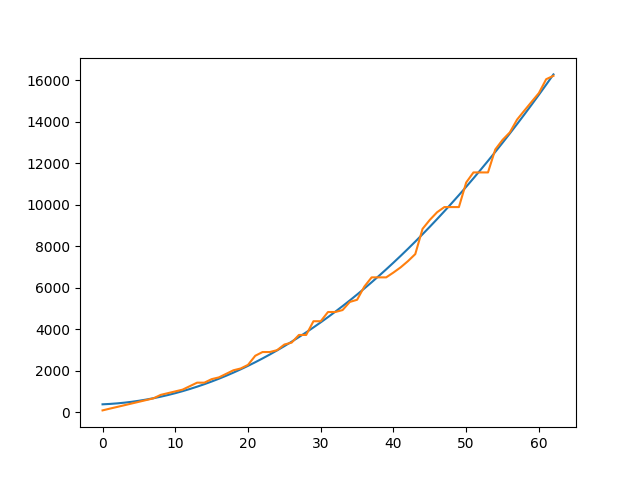

In [9]:
plt.figure()
plt.plot(fit[2]+number*fit[1]+number**2*fit[0])
plt.plot(b)

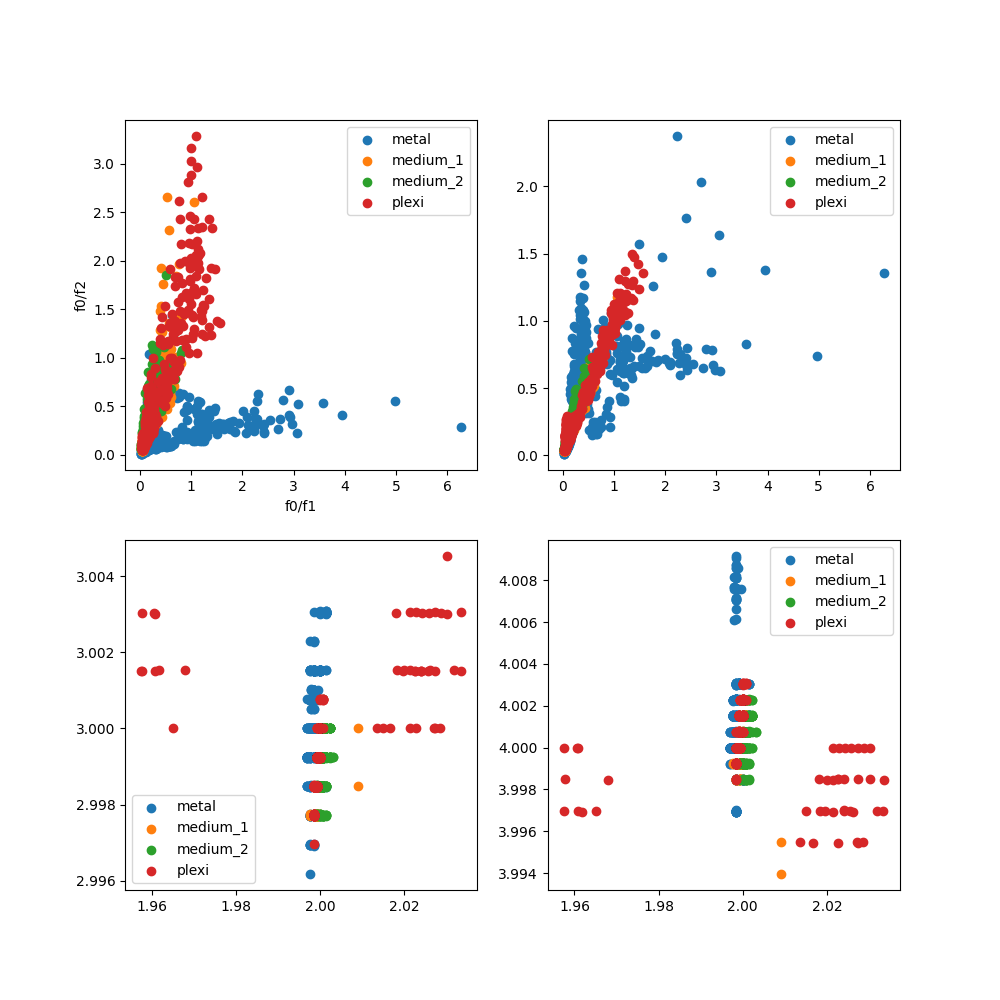

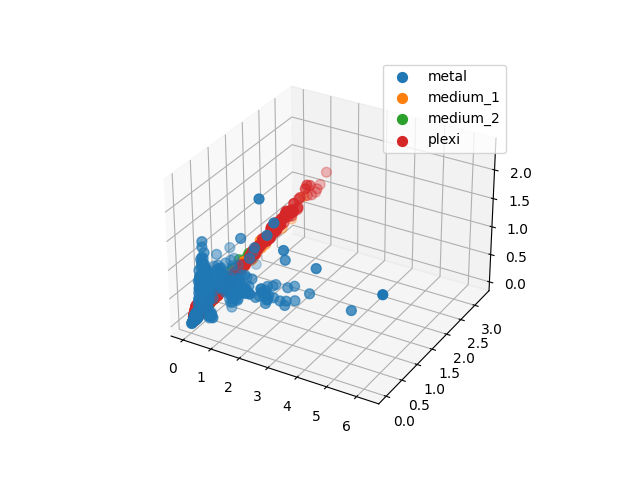

In [10]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig_3D = plt.figure()
ax_3D = plt.axes(projection='3d')

for repertoire in liste_repertoire:
    liste_fo_f_1_amp = []
    liste_fo_f_2_amp = []
    liste_fo_f_3_amp = []
    liste_fo_f_1_freq = []
    liste_fo_f_2_freq = []
    liste_fo_f_3_freq = []
    for cle in dict_harmo_amp[repertoire].keys():
        
        
        liste_fo_f_1_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][1])
        liste_fo_f_2_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][2])
        liste_fo_f_3_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][3])
        
        
        liste_fo_f_1_freq.append(dict_harmo_freq[repertoire][cle][1]/dict_harmo_freq[repertoire][cle][0])
        liste_fo_f_2_freq.append(dict_harmo_freq[repertoire][cle][2]/dict_harmo_freq[repertoire][cle][0])
        liste_fo_f_3_freq.append(dict_harmo_freq[repertoire][cle][3]/dict_harmo_freq[repertoire][cle][0])
        
    ax_3D.scatter3D(liste_fo_f_1_amp,liste_fo_f_2_amp,liste_fo_f_3_amp,marker ='o', s=50, label=repertoire[25:-1])
    #ax_3D.scatter3D(liste_fo_f_1_freq,liste_fo_f_2_freq,liste_fo_f_3_freq,marker ='o', s=50, label=repertoire[25:-1])
    ax[0,0].scatter(liste_fo_f_1_amp,liste_fo_f_2_amp,label=repertoire[25:-1])
    ax[1,0].scatter(liste_fo_f_1_freq,liste_fo_f_2_freq,label=repertoire[25:-1])
    ax[0,1].scatter(liste_fo_f_1_amp,liste_fo_f_3_amp,label=repertoire[25:-1])
    ax[1,1].scatter(liste_fo_f_1_freq,liste_fo_f_3_freq,label=repertoire[25:-1])
    
    ax[0,0].set_xlabel('f0/f1')
    ax[0,0].set_ylabel('f0/f2')
    
    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    ax_3D.legend()

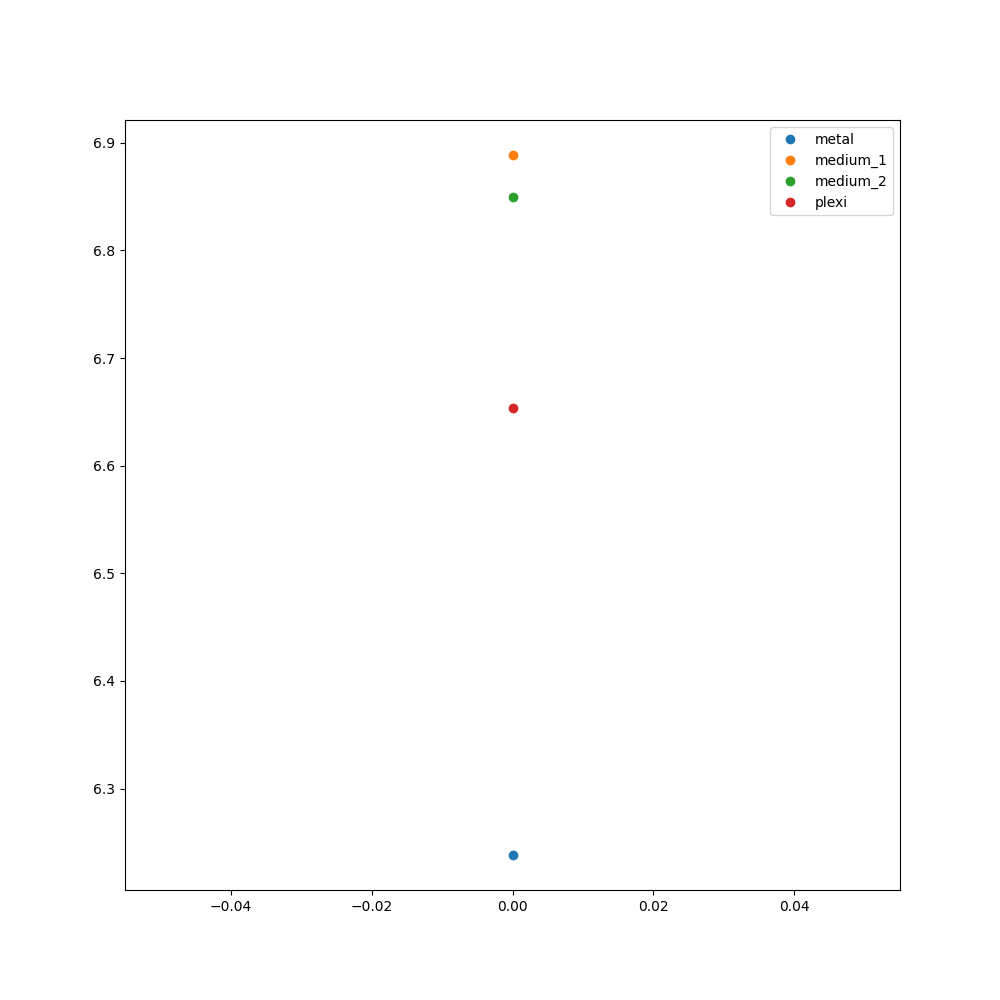

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))
for repertoire in liste_repertoire:
    liste_b = []
    for cle in dict_harmo_amp[repertoire].keys():
        a=dict_harmo_freq[repertoire][cle]
        b=dict_harmo_freq_hz_v[repertoire][a]
        number=np.linspace(0,len(b),len(b))
        fit = np.polyfit(number, dict_harmo_freq_hz_v[repertoire][a], 2)
        liste_b.append(fit[0])
    
    ax.plot(np.mean(liste_b),"o",label=repertoire[25:-1])
    ax.legend()

In [12]:
def harmo_exp(all_cle,data,Fe,L_n,Nfft,H=4,fmin_hz=50,fmax_hz=900):
    dict_harmo_amp_data={}
    dict_harmo_freq_data={}
    dict_harmo_freq_hz_v={}
    for cle in all_cle:
        fftFreq_hz_v, fftAmpl_v = F_getSpectreFromAudio(data[cle] , L_n, Nfft, Fe)
        spFreq_hz_v, spAmpl_v, f0_hz = F_getF0FromSpectre(fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, Fe)
        harmoFreq_k_v, harmoAmpl_v = F_getHarmonicsFromF0AndSpectre(fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, Fe)
        dict_harmo_amp_data[cle] = harmoAmpl_v
        dict_harmo_freq_data[cle] = harmoFreq_k_v
        dict_harmo_freq_hz_v[cle]=fftFreq_hz_v
    return dict_harmo_amp_data,dict_harmo_freq_data,dict_harmo_freq_hz_v

In [13]:
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise_hr/harmo/'
Fe_exp=22050



fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
data_experience = {}
for matiere in fichiers_table:
    fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
    for corde in fichiers_corde:
        fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
        for mat in fichiers_mat:
            if mat != ".DS_Store":
                fs=Fe_exp
                sig,_ = librosa.load(monRepertoire_experience+matiere+'/'+corde+'/'+mat,sr=Fe_exp)
                data_experience[matiere+'_'+corde+'_'+mat] = sig/np.max(np.abs(sig))
                



In [14]:
L_sec_exp = 2
L_n_exp= int(L_sec_exp*Fe_exp)
Nfft_exp = 4*tpt_tools.nextpow2(L_n_exp)
all_cle_exp = list(data_experience.keys())

dict_harmo_amp_exp,dict_harmo_freq_exp,dict_harmo_freq_hz_v_exp = harmo_exp(all_cle_exp,data_experience,Fe_exp,L_n_exp,Nfft_exp,H=4)

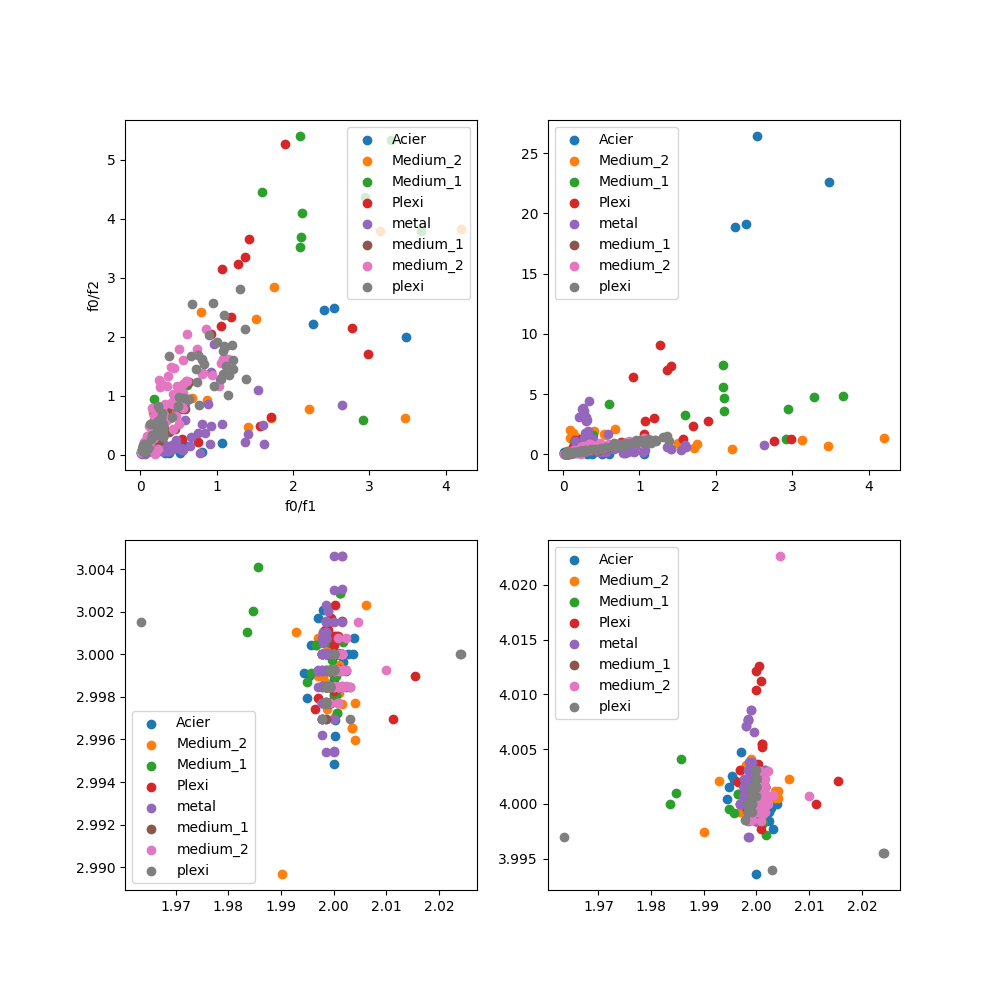

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,10))


liste_fo_f1_amp =[]
liste_fo_f2_amp=[]
liste_fo_f3_amp=[]
liste_fo_f1_freq=[]
liste_fo_f2_freq=[]
liste_fo_f3_freq=[]
for cle in all_cle_exp:
    if  'Metal' in cle and 'Acier' in cle:
        liste_fo_f1_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][1])
        liste_fo_f2_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][2])
        liste_fo_f3_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][3])
        
        liste_fo_f1_freq.append(dict_harmo_freq_exp[cle][1]/dict_harmo_freq_exp[cle][0])
        liste_fo_f2_freq.append(dict_harmo_freq_exp[cle][2]/dict_harmo_freq_exp[cle][0])
        liste_fo_f3_freq.append(dict_harmo_freq_exp[cle][3]/dict_harmo_freq_exp[cle][0])
ax[0,0].scatter(liste_fo_f1_amp,liste_fo_f2_amp,label='Acier')
ax[1,0].scatter(liste_fo_f1_freq,liste_fo_f2_freq,label='Acier')
ax[0,1].scatter(liste_fo_f1_amp,liste_fo_f3_amp,label='Acier')
ax[1,1].scatter(liste_fo_f1_freq,liste_fo_f3_freq,label='Acier')

ax[0,0].legend()
ax[1,0].legend()
ax[0,1].legend()
ax[1,1].legend()

liste_fo_f1_amp =[]
liste_fo_f2_amp=[]
liste_fo_f3_amp=[]
liste_fo_f1_freq=[]
liste_fo_f2_freq=[]
liste_fo_f3_freq=[]
for cle in all_cle_exp:
    if  'Medium_2' in cle and 'Acier' in cle:
        liste_fo_f1_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][1])
        liste_fo_f2_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][2])
        liste_fo_f3_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][3])
        
        liste_fo_f1_freq.append(dict_harmo_freq_exp[cle][1]/dict_harmo_freq_exp[cle][0])
        liste_fo_f2_freq.append(dict_harmo_freq_exp[cle][2]/dict_harmo_freq_exp[cle][0])
        liste_fo_f3_freq.append(dict_harmo_freq_exp[cle][3]/dict_harmo_freq_exp[cle][0])
ax[0,0].scatter(liste_fo_f1_amp,liste_fo_f2_amp,label='Medium_2')
ax[1,0].scatter(liste_fo_f1_freq,liste_fo_f2_freq,label='Medium_2')
ax[0,1].scatter(liste_fo_f1_amp,liste_fo_f3_amp,label='Medium_2')
ax[1,1].scatter(liste_fo_f1_freq,liste_fo_f3_freq,label='Medium_2')

ax[0,0].legend()
ax[1,0].legend()
ax[0,1].legend()
ax[1,1].legend()

liste_fo_f1_amp =[]
liste_fo_f2_amp=[]
liste_fo_f3_amp=[]
liste_fo_f1_freq=[]
liste_fo_f2_freq=[]
liste_fo_f3_freq=[]
for cle in all_cle_exp:
    if  'Medium_1' in cle and 'Acier' in cle:
        liste_fo_f1_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][1])
        liste_fo_f2_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][2])
        liste_fo_f3_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][3])
        
        liste_fo_f1_freq.append(dict_harmo_freq_exp[cle][1]/dict_harmo_freq_exp[cle][0])
        liste_fo_f2_freq.append(dict_harmo_freq_exp[cle][2]/dict_harmo_freq_exp[cle][0])
        liste_fo_f3_freq.append(dict_harmo_freq_exp[cle][3]/dict_harmo_freq_exp[cle][0])
ax[0,0].scatter(liste_fo_f1_amp,liste_fo_f2_amp,label='Medium_1')
ax[1,0].scatter(liste_fo_f1_freq,liste_fo_f2_freq,label='Medium_1')
ax[0,1].scatter(liste_fo_f1_amp,liste_fo_f3_amp,label='Medium_1')
ax[1,1].scatter(liste_fo_f1_freq,liste_fo_f3_freq,label='Medium_1')

ax[0,0].legend()
ax[1,0].legend()
ax[0,1].legend()
ax[1,1].legend()

liste_fo_f1_amp =[]
liste_fo_f2_amp=[]
liste_fo_f3_amp=[]
liste_fo_f1_freq=[]
liste_fo_f2_freq=[]
liste_fo_f3_freq=[]
for cle in all_cle_exp:
    if  'Plexi' in cle and 'Acier' in cle:
        liste_fo_f1_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][1])
        liste_fo_f2_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][2])
        liste_fo_f3_amp.append(dict_harmo_amp_exp[cle][0]/dict_harmo_amp_exp[cle][3])
        
        liste_fo_f1_freq.append(dict_harmo_freq_exp[cle][1]/dict_harmo_freq_exp[cle][0])
        liste_fo_f2_freq.append(dict_harmo_freq_exp[cle][2]/dict_harmo_freq_exp[cle][0])
        liste_fo_f3_freq.append(dict_harmo_freq_exp[cle][3]/dict_harmo_freq_exp[cle][0])
ax[0,0].scatter(liste_fo_f1_amp,liste_fo_f2_amp,label='Plexi')
ax[1,0].scatter(liste_fo_f1_freq,liste_fo_f2_freq,label='Plexi')
ax[0,1].scatter(liste_fo_f1_amp,liste_fo_f3_amp,label='Plexi')
ax[1,1].scatter(liste_fo_f1_freq,liste_fo_f3_freq,label='Plexi')

ax[0,0].legend()
ax[1,0].legend()
ax[0,1].legend()
ax[1,1].legend()

for repertoire in liste_repertoire:

    liste_fo_f_1_amp = []
    liste_fo_f_2_amp = []
    liste_fo_f_3_amp = []
    liste_fo_f_1_freq = []
    liste_fo_f_2_freq = []
    liste_fo_f_3_freq = []
    for cle in dict_harmo_amp[repertoire].keys():

        liste_fo_f_1_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][1])
        liste_fo_f_2_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][2])
        liste_fo_f_3_amp.append(dict_harmo_amp[repertoire][cle][0]/dict_harmo_amp[repertoire][cle][3])


        liste_fo_f_1_freq.append(dict_harmo_freq[repertoire][cle][1]/dict_harmo_freq[repertoire][cle][0])
        liste_fo_f_2_freq.append(dict_harmo_freq[repertoire][cle][2]/dict_harmo_freq[repertoire][cle][0])
        liste_fo_f_3_freq.append(dict_harmo_freq[repertoire][cle][3]/dict_harmo_freq[repertoire][cle][0])

    #ax_3D.scatter3D(liste_fo_f_1_amp,liste_fo_f_2_amp,liste_fo_f_3_amp,marker ='o', s=50, label=repertoire[25:-1])
    #ax_3D.scatter3D(liste_fo_f_1_freq,liste_fo_f_2_freq,liste_fo_f_3_freq,marker ='o', s=50, label=repertoire[25:-1])
    ax[0,0].scatter(liste_fo_f_1_amp,liste_fo_f_2_amp,label=repertoire[25:-1])
    ax[1,0].scatter(liste_fo_f_1_freq,liste_fo_f_2_freq,label=repertoire[25:-1])
    ax[0,1].scatter(liste_fo_f_1_amp,liste_fo_f_3_amp,label=repertoire[25:-1])
    ax[1,1].scatter(liste_fo_f_1_freq,liste_fo_f_3_freq,label=repertoire[25:-1])

    ax[0,0].set_xlabel('f0/f1')
    ax[0,0].set_ylabel('f0/f2')

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()


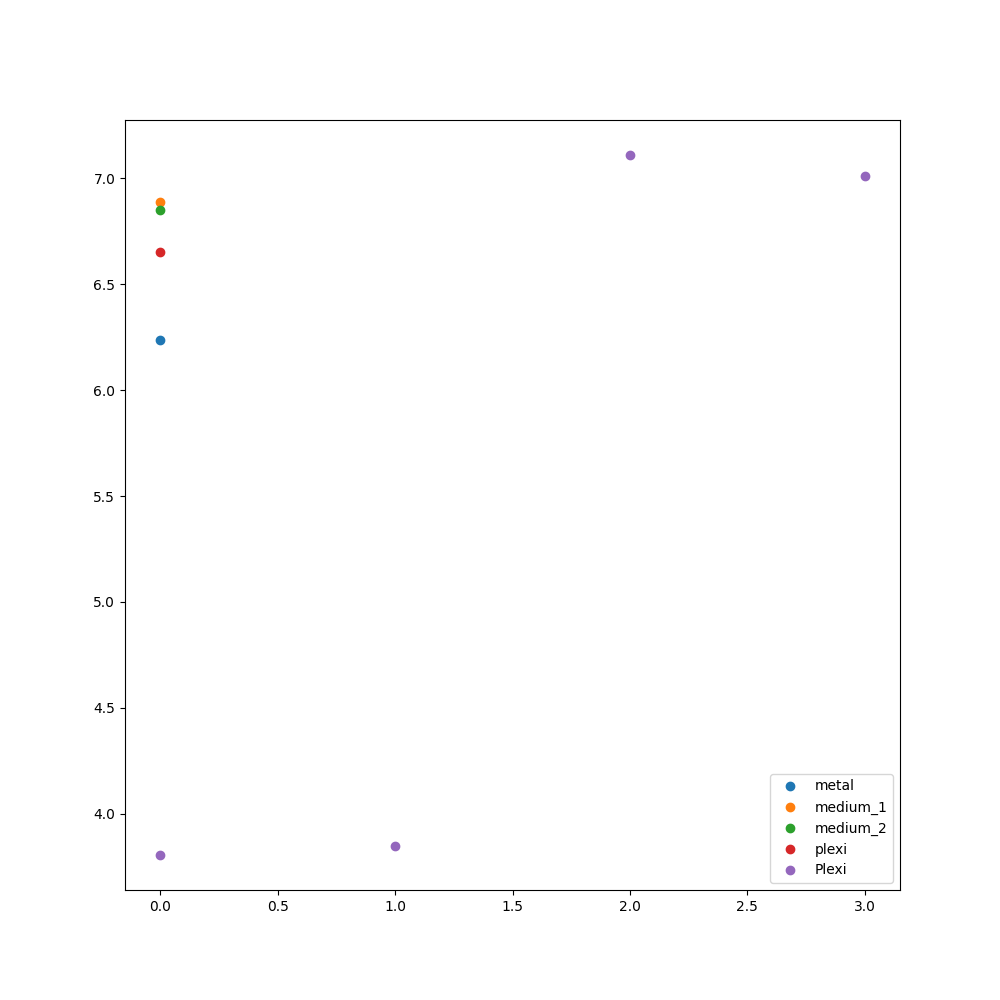

In [83]:
fig, ax = plt.subplots(1, figsize=(10,10))
for repertoire in liste_repertoire:
    liste_b = []
    for cle in dict_harmo_amp[repertoire].keys():
        a=dict_harmo_freq[repertoire][cle]
        b=dict_harmo_freq_hz_v[repertoire][a]
        number=np.linspace(0,len(b),len(b))
        fit = np.polyfit(number, dict_harmo_freq_hz_v[repertoire][a], 2)
        liste_b.append(fit[0])
    
    ax.plot(np.mean(liste_b),"o",label=repertoire[25:-1])
    ax.legend()
    
liste_b = []
for cle in all_cle_exp:
    if  'C_1' in cle and 'Plexi' in cle and 'Acier' in cle:
        a=dict_harmo_freq_exp[cle]
        b=dict_harmo_freq_hz_v_exp[cle][a]
        number=np.linspace(0,len(b),len(b))
        fit = np.polyfit(number, dict_harmo_freq_hz_v_exp[cle][a], 2)
        liste_b.append(fit[0])
ax.plot(liste_b,"o",label='Plexi')

ax.legend()